# Fetching data from [cryptocompare.com](https://www.cryptocompare.com)

In [2]:
import requests

class CryptoApi:
    def __init__(self) -> None:
        self.mother_endpoint = "https://min-api.cryptocompare.com/data"

        with open('token.txt', 'r') as f:
            self.TOKEN = f.readline()

        self.HEADER = {'Authorization': self.TOKEN,
                       "Content-Type": 'application/json'}


    def get_data(self, crypto:str, currency:str, period:str, period_count:int, allData=0):
        '''Returns crypto summary for a given period in specified currency.

        Args:
            crypto: str
                BTC/ETH/DOGE etc.
            currency: str
                USD/EUR/UAH etc.
            period: str 
                day/hour/minute.
            period_count: int
                last n of a period (n days)
                n = 1 returns revious day/hour/minute + current
            allData: int
                bool doen't work
                1 - get all records;
                0 - get specified amount of period_count.
        Returns:
            dict: json containing request's response.
        '''        

        endpoint = f'{self.mother_endpoint}/v2/histo{period}?fsym={crypto}&tsym={currency}&limit={period_count}'
        response = requests.get(endpoint, params={'allData':allData}, headers=self.HEADER)
        
        return response.json()
    
    def execute_custom_getrequest(self, endpoint:str):
        return requests.get(endpoint, headers=self.HEADER)
    
data = CryptoApi()
#data.get_data('btc','usd','day',29)

In [3]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed


date_range = pd.date_range(start='2023-04-11', end='2023-04-13', freq='d')

queries = [f"from:elonmusk since:{d1.strftime('%Y-%m-%d')} until:{d2.strftime('%Y-%m-%d')}"
           for d1, d2 in zip(date_range, date_range[1:])]


def parallel_download_tweets():
    def sequent_download_tweets(query):
        tweets = []
        for tweet in sntwitter.TwitterSearchScraper(query).get_items():
            tweets.append(tweet)
        return tweets

    tweets_list = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(sequent_download_tweets, query) for query in queries]
            
        # Append results to the tweets list
        for future in as_completed(futures):
            tweets_list += future.result()
            
    return tweets_list


#tweets_df = pd.DataFrame(parallel_download_tweets())
#tweets_df.to_csv('elon_twt.csv')

In [4]:
raw_data = data.get_data('btc','usd','day',30)

In [5]:
from datetime import datetime

df = pd.DataFrame(raw_data['Data']['Data'])
df['time'] = df['time'].apply(lambda x: datetime.fromtimestamp(x).date())

In [6]:
raw_btc = data.get_data('btc','usd','day', 2000) #10 years bitcoin

In [7]:
btc_df = pd.DataFrame(raw_btc['Data']['Data'])
btc_df['time'] = btc_df['time'].apply(lambda x: datetime.fromtimestamp(x).date())

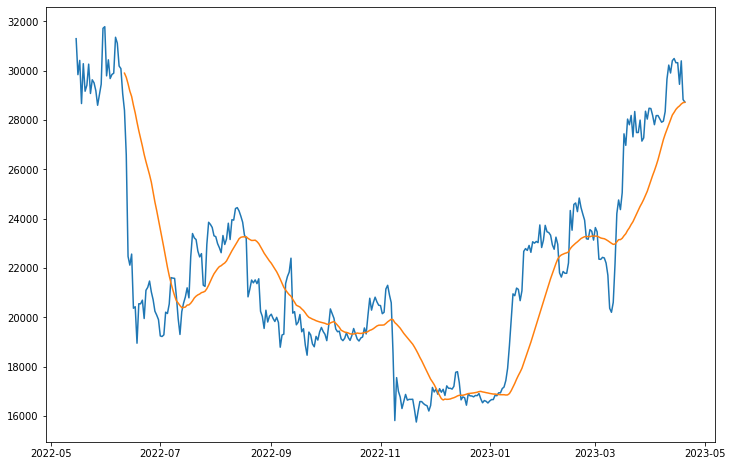

In [8]:
import matplotlib.pyplot as plt

filtered_df = btc_df[btc_df['time']>=datetime.strptime('2022-05-15','%Y-%m-%d').date()].copy()
filtered_df.index = filtered_df['time']


plt.figure(figsize=(12,8))
plt.plot(filtered_df['close'])
plt.plot(filtered_df['close'].rolling(28).mean())

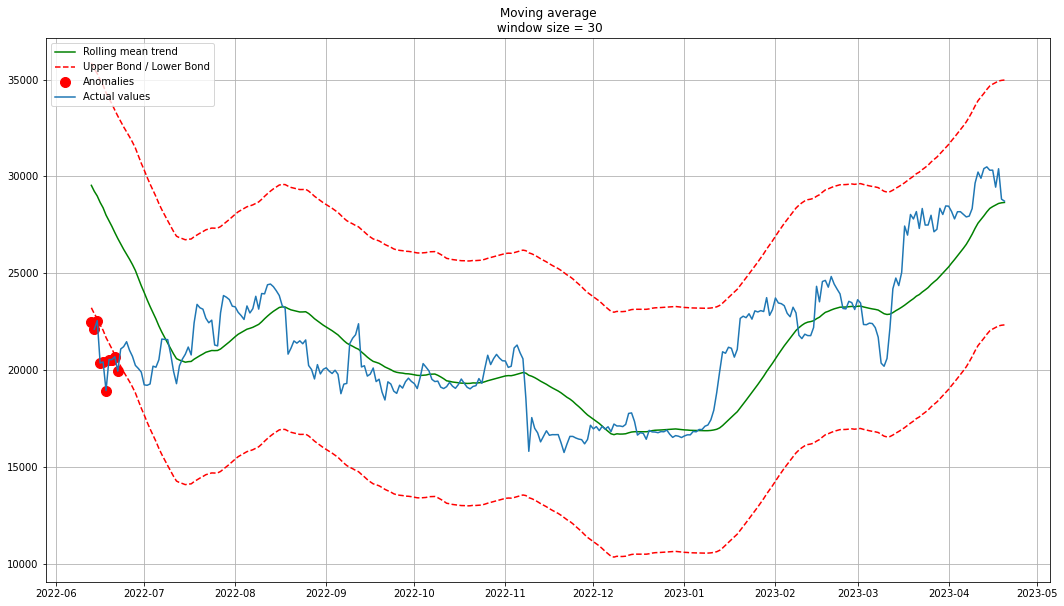

In [9]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(18,10))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10, label='Anomalies')
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
plotMovingAverage(filtered_df[['close']], 30, plot_intervals=True, plot_anomalies=True)

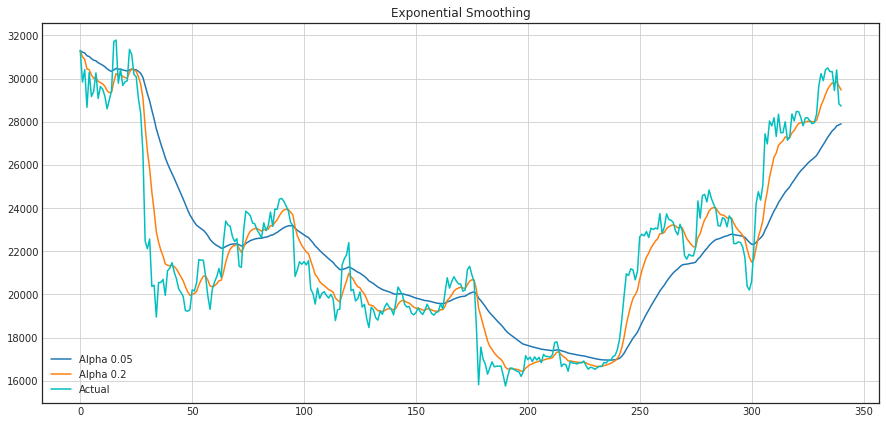

In [10]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha}")
            
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)
        
#plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])
plotExponentialSmoothing(filtered_df['close'], [0.05, 0.2])

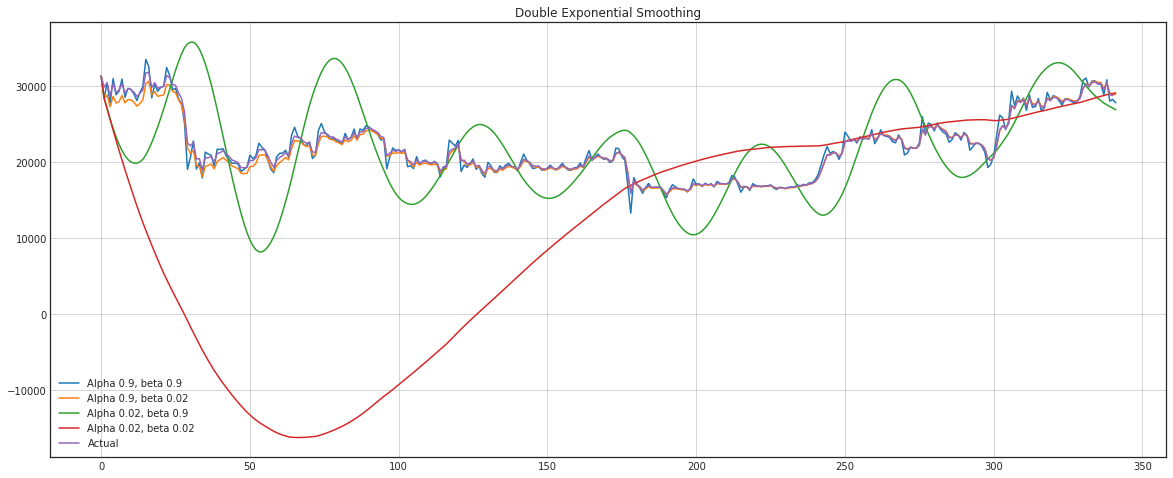

In [11]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(filtered_df['close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Analysis of tweets

In [34]:
import pandas as pd

tweets_df = pd.read_csv('elon_tweets.csv', index_col=0)
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

def select_notna_cols(df: pd.DataFrame, threshold: float):
    """
    Selects columns with at least the specified proportion of non-null values.
    
    Args:
        df (pandas.DataFrame): DataFrame to select columns from.
        threshold (float): The minimum proportion of non-null values a column must have to be selected.
    
    Returns:
        List[str]: The names of the selected columns.
    """

    proportions = df.notnull().mean()
    selected_cols = proportions[proportions >= threshold].index.tolist()
    
    return selected_cols

notna_cols = select_notna_cols(tweets_df, threshold=0.4)
mod_tweets_df = tweets_df[notna_cols].copy()

In [13]:
'''
TODO: 
0) group tweets by day
1) merge 2 datasets into 1
2) imput missing data, maybe try interpolation or expectation maximization
3) ivestigate relationship within data, maybe correlation matrix etc
'''

#data.get_data('btc', 'usd', 2000)

'\nTODO: \n0) group tweets by day\n1) merge 2 datasets into 1\n2) imput missing data, maybe try interpolation or expectation maximization\n3) ivestigate relationship within data, maybe correlation matrix etc\n'

In [35]:
mod_tweets_df = (mod_tweets_df[mod_tweets_df['lang']=='en']
                 .drop(['id','url','source','sourceUrl'], axis=1)
                 .reset_index(drop=True)
                 .copy())
#print(tweets_df.columns)
mod_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   date              18316 non-null  datetime64[ns, UTC]
 1   rawContent        18316 non-null  object             
 2   renderedContent   18316 non-null  object             
 3   user              18316 non-null  object             
 4   replyCount        18316 non-null  int64              
 5   retweetCount      18316 non-null  int64              
 6   likeCount         18316 non-null  int64              
 7   quoteCount        18316 non-null  int64              
 8   conversationId    18316 non-null  int64              
 9   lang              18316 non-null  object             
 10  sourceLabel       18316 non-null  object             
 11  inReplyToTweetId  14025 non-null  float64            
 12  inReplyToUser     14025 non-null  object             
 13  m